# pPXF: NIRSpec/JWST mock spectrum at redshift $z\approx3$

Usage example for the procedure pPXF originally described in [Cappellari & Emsellem (2004)](http://adsabs.harvard.edu/abs/2004PASP..116..138C), substantially upgraded in [Cappellari (2017)](http://adsabs.harvard.edu/abs/2017MNRAS.466..798C) and with the inclusion of photometry and linear constraints in [Cappellari (2022)](https://ui.adsabs.harvard.edu/abs/2022arXiv220814974C).

* V1.0.0: Michele Cappellari, Oxford, 29 March 2022: Created
* V1.1.0: MC, Oxford, 10 June 2022: Updated for `pPXF` 8.1 using new `util.synthetic_photometry`
* V1.2.0: MC, Oxford, 7 September 2022: Updated for pPXF 8.2

![pPXF](https://www-astro.physics.ox.ac.uk/~cappellari/software/ppxf_logo.svg)


In [56]:
from os import path

import matplotlib.pyplot as plt
import numpy as np

from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.miles_util as lib

## Read the galaxy spectrum and de-redshift it

In [57]:
data = np.load("ppxf_high_redshift_mock_spectrum.npz")
lam, galaxy = data["lam"], data["galaxy"]

In [58]:
# %matplotlib widget
# %matplotlib inline

JWST/NIRSpec G235H/F170LP covers the observed wavelength range $\lambda=1.66–3.17$ μm with a quoted resolving power $R \approx 2700$.

We can compute the spectral resolution in wavelength units assuming it is approximately constant. The spectral resolution FWHM is, by definition of resolving power, and using as reference the geometric mean of the wavelength
<br>

$\Delta\lambda=\frac{\lambda}{R}\approx\frac{\sqrt{\lambda_{\rm min}\lambda_{\rm max}}}{R}$

In [59]:
R = 2700
FWHM_gal = 1e4*np.sqrt(1.66*3.17)/R  
print( f"FWHM_gal: {FWHM_gal:.1f} Å")   # 8.5 Angstrom  

FWHM_gal: 8.5 Å


It is also useful to know the instrumental dispersion in km/s
 <br>

$\sigma_{\rm inst}\approx\frac{c}{R\sqrt{4\ln{4}}}$

In [60]:
c = 299792.458                      # speed of light in km/s
sigma_inst = c/(R*2.355)
print( f"sigma_inst: {sigma_inst:.0f} km/s")   # 47 km/s

sigma_inst: 47 km/s


It is generally simpler to de-redshift the spectrum before performing the pPXF fit.
Crucially, one has to correct the instrumental resolution in wavelength units too.

In [61]:
z = 3.000                       # Initial estimate of the galaxy redshift
lam /= (1 + z)               # Compute approximate restframe wavelength
FWHM_gal /= (1 + z)     # Adjust resolution in Angstrom
print(f"de-redshifted NIRSpec G235H/F170LP resolution FWHM in Å: {FWHM_gal:.1f}")

de-redshifted NIRSpec G235H/F170LP resolution FWHM in Å: 2.1


I assume a constant error spectrum `noise` per spectral pixel. This is often a good approximation and I can correct later for the scaling, after obtaining the residuials from the fit.

In [62]:
galaxy = galaxy/np.median(galaxy)       # Normalize spectrum to avoid numerical issues
noise = np.full_like(galaxy, 0.05)      # Assume constant noise per pixel here. I adopt a noise that gives chi2/DOF~1

## Setup spectral templates

The template has a larger dispersion than the galaxy: I do **not** broaden the templates.
But I need to correct the measured velocity dispersion later.

The galaxy spectrum was already log-rebinned. I measure the adopted velocity scale for the data.

In [63]:
velscale = c*np.log(lam[1]/lam[0])  # eq.(8) of Cappellari (2017)
print(f"Velocity scale per pixel: {velscale:.2f} km/s")

Velocity scale per pixel: 47.00 km/s


In [64]:
FWHM_temp = 2.51   # Resolution of E-MILES templates in the fitted range

The templates are normalized to the V-band using norm_range. In this way the weights returned by pPXF represent V-band light fractions of each SSP.
I limit the age of the templates to the age $T\approx2.2$ Gyr of the Universe at $z=3$.

In [65]:
ppxf_dir = path.dirname(path.realpath(lib.__file__))
pathname = ppxf_dir + '/miles_models/Eun1.30*.fits'
miles = lib.miles(pathname, velscale, norm_range=[5070, 5950], age_range=[0, 2.2])

The stellar templates are reshaped below into a 2-dim array with each spectrum as a column, however we save the original array dimensions ``reg_dim``, which are needed to specify the regularization dimensions

In [66]:
reg_dim = miles.templates.shape[1:]
stars_templates = miles.templates.reshape(miles.templates.shape[0], -1)

Construct a set of Gaussian emission line templates.

The `emission_lines` function defines the most common lines, but additional lines can be included by editing the function in the file `ppxf_util.py`.

In [67]:
lam_range_gal = [np.min(lam), np.max(lam)]
gas_templates, gas_names, line_wave = util.emission_lines(miles.ln_lam_temp, lam_range_gal, FWHM_gal, tie_balmer=1)

Emission lines included in gas templates:
['Balmer' '[SII]6716' '[SII]6731' 'HeII4687' 'HeI5876' '[OIII]5007_d'
 '[OI]6300_d' '[NII]6583_d']


Combines the stellar and gaseous templates into a single array. During the pPXF fit they will be assigned a different kinematic `component` value

In [68]:
templates = np.column_stack([stars_templates, gas_templates])

## Setup pPXF parameters

As the spectrum was deredshifted, the starting guess for the velocity becomes close to zero

In [69]:
c = 299792.458
start = [1200, 200.]     # (km/s), starting guess for [V, sigma]

I fit two kinematics components, one for the stars and one for the gas.
Assign `component=0` to the stellar templates, `component=1` to the gas.

In [70]:
n_stars = stars_templates.shape[1]
n_gas = len(gas_names)
component = [0]*n_stars + [1]*n_gas
gas_component = np.array(component) > 0  # gas_component=True for gas templates

Fit (V, sig) moments=2 for both the stars and the gas

In [71]:
moments = [2, 2]

Adopt the same starting value for both the stars and the gas components

In [72]:
start = [start, start]

## Start pPXF fit

 Best Fit:       Vel     sigma
 comp.  0:      1246       131
 comp.  1:      1243       127
Stars Attenuation A_V: 0.880
  Gas Attenuation A_V: 1.227
chi2/DOF: 0.9535; DOF: 4119; degree = -1; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 51; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 13/104
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1                Balmer      8.837      0.22    1243   127
Comp:  1             [SII]6716      1.276      0.16    1243   127
Comp:  1             [SII]6731      1.088      0.16    1243   127
Comp:  1              HeII4687      0.000      0.16    1243   127
Comp:  1               HeI5876     0.2618      0.16    1243   127
Comp:  1          [OIII]5007_d      1.706      0.20    1243   127
Comp:  1            [OI]6300_d     0.1390      0.20    1243   127
Comp:  1           

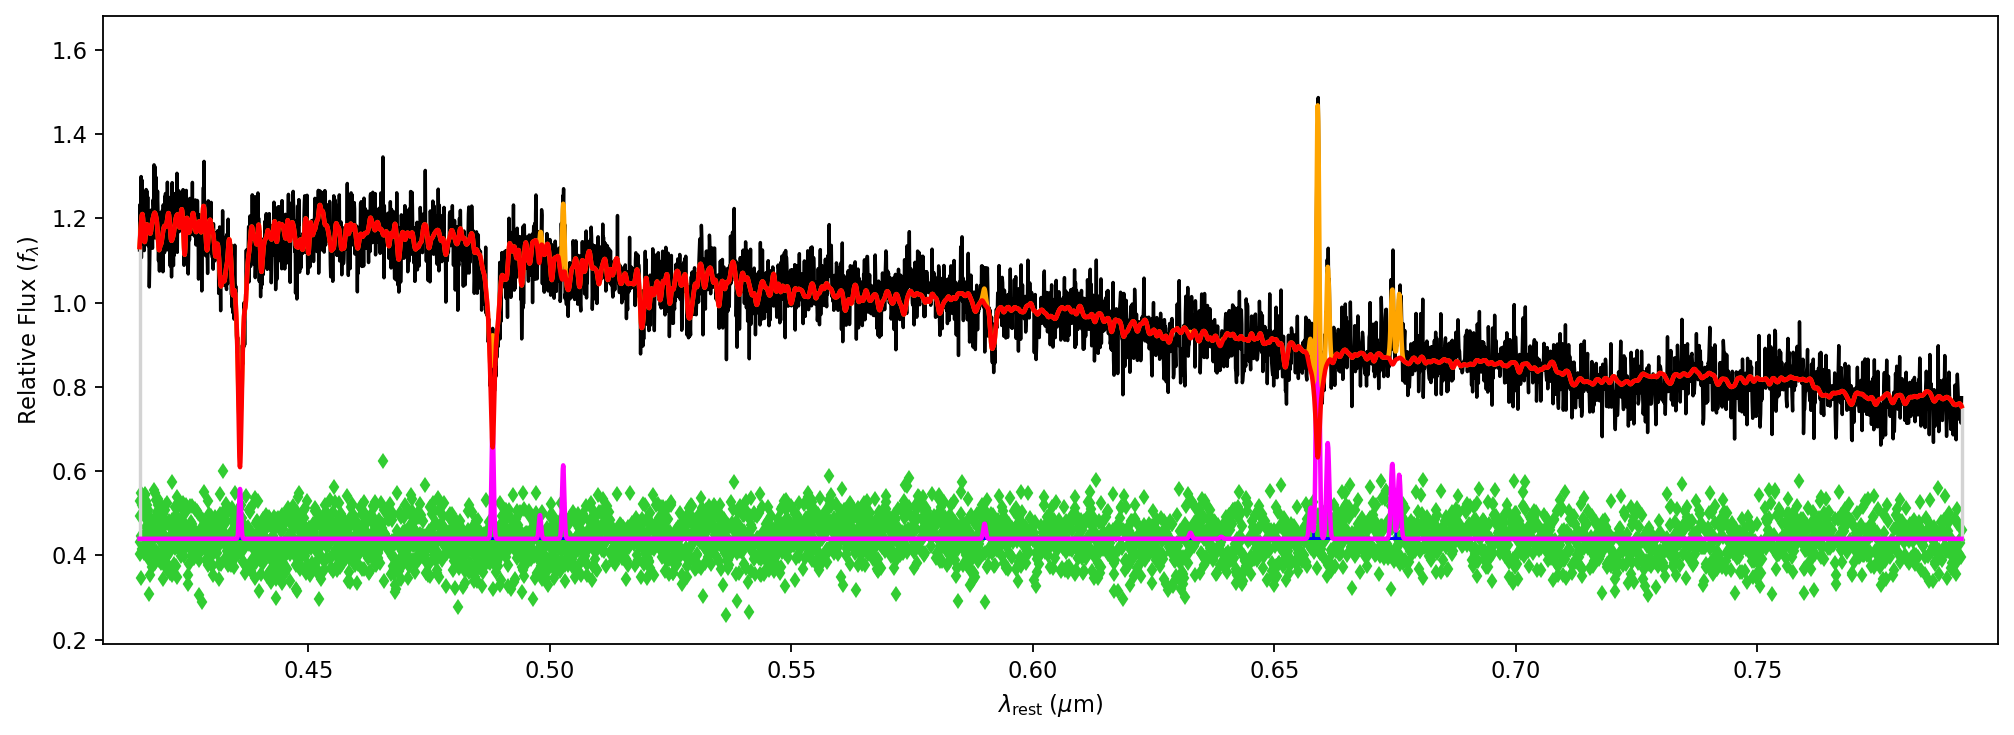

In [73]:
pp = ppxf(templates, galaxy, noise, velscale, start,
          moments=moments, degree=-1, mdegree=-1, lam=lam, lam_temp=miles.lam_temp,
          reg_dim=reg_dim, component=component, gas_component=gas_component,
          reddening=0, gas_reddening=0, gas_names=gas_names)
plt.figure(figsize=(15, 5))
pp.plot()

Zoom into H$\gamma$, H$\beta$ and [OIII] spectral region

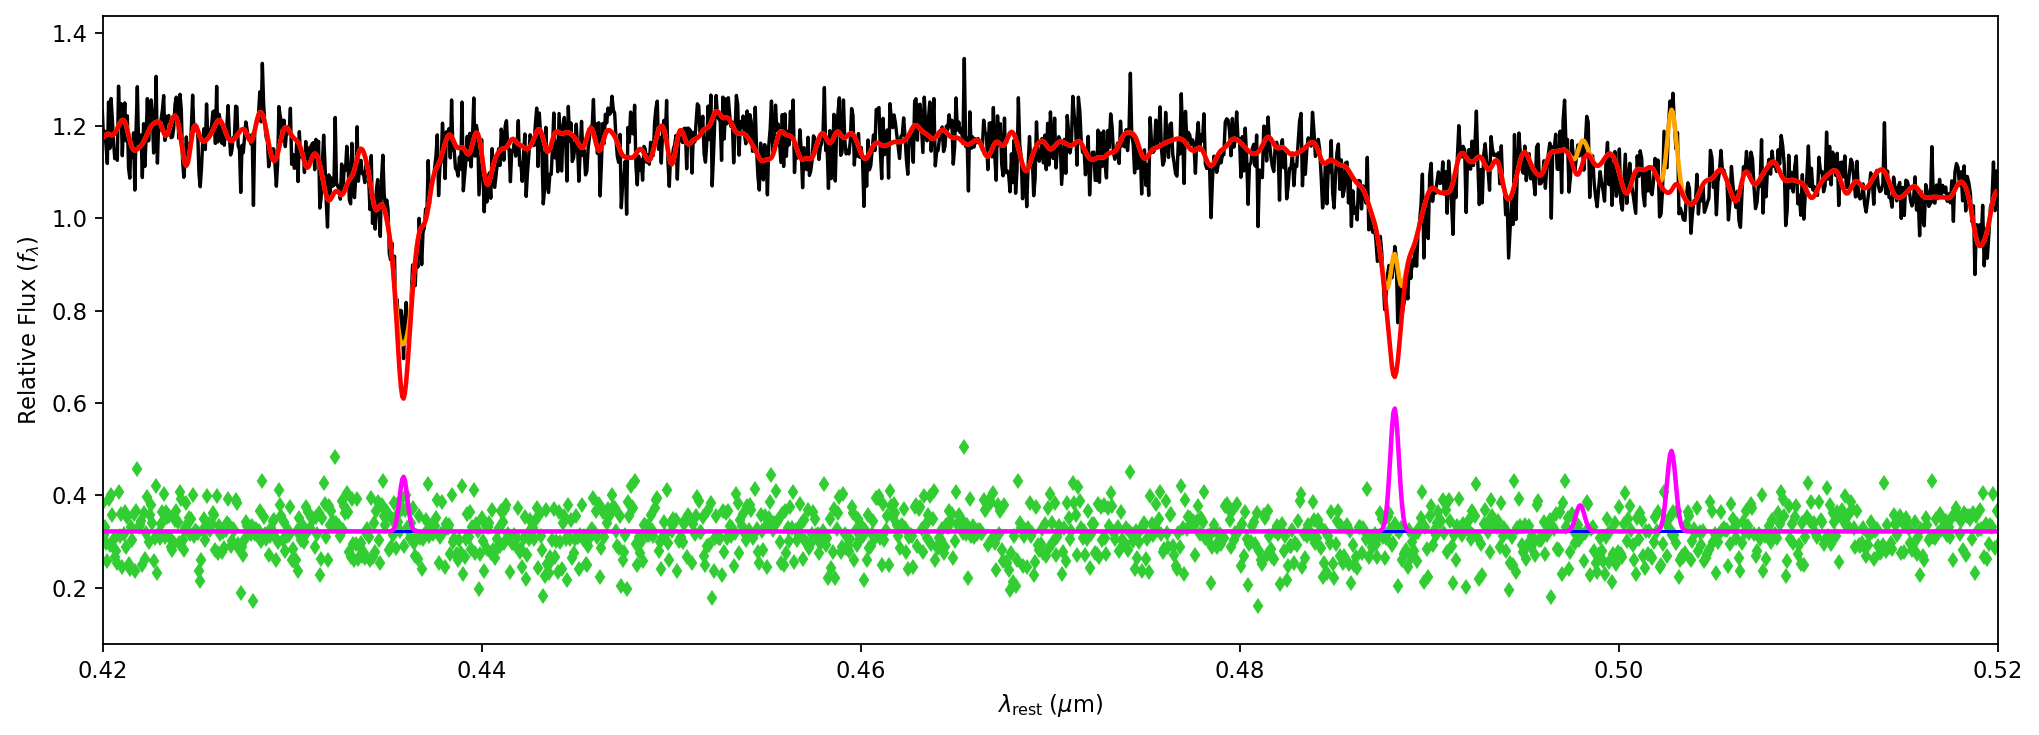

In [74]:
plt.figure(figsize=(15, 5))
pp.plot(gas_clip=1)
plt.xlim([0.42, 0.52]);

IMPORTANT: As the templates have larger instrumental dispersion than the galaxy spectrum, and for this reason it was not possible to match the resolutions of the templates before the fit, I now need to correct the fitted sigma by the quadratic differences in instrumental resolutions. In this case the correction is negligible, but in general it cannot be ignored.
<br/>

$\sigma_{\rm obs}^2=\sigma_\star^2 + \sigma_{\rm inst}^2$

In [75]:
lam_med = np.median(lam)  # Angstrom
sigma_gal = c*FWHM_gal/lam_med/2.355  # in km/s
sigma_temp = c*FWHM_temp/lam_med/2.355
sigma_obs = pp.sol[0][1]   # sigma is second element of first kinematic component
sigma_diff2 = sigma_gal**2 - sigma_temp**2   # eq. (5) of Cappellari (2017)
sigma = np.sqrt(sigma_obs**2 - sigma_diff2)
print(f"sigma stars corrected: {sigma:.0f} km/s")

sigma stars corrected: 134 km/s


Uncertainties on stellar kinematics.
More accurate ones can be obtained with bootstrapping.

In [76]:
errors = pp.error[0]*np.sqrt(pp.chi2)      # assume the fit is good
print("Formal errors:")
print("   dV   dsigma")
print("".join("%6.2g" % f for f in errors))

Formal errors:
   dV   dsigma
   6.9   8.6


An improved estimate of the best-fitting redshift is given by the following lines using equation 5 of [Cappellari (2022)](https://ui.adsabs.harvard.edu/abs/2022arXiv220814974C).

In [77]:
vpec = pp.sol[0][0]                         # This is the fitted residual velocity in km/s
znew = (1 + z)*np.exp(vpec/c) - 1           # eq.(5c) Cappellari (2022)
dznew = (1 + z)*errors[0]/c                 # eq.(5d) Cappellari (2022)
print(f"Best-fitting redshift z = {znew:#.6f} +/- {dznew:#.2g}")

Best-fitting redshift z = 3.016665 +/- 9.1e-05


# Include the photometric measurements in the fit

## Observed galaxy photometric fluxes

Mean galaxy fluxes in the photometric bands `[i, z, Y, J, H, K]`. Bluer bands fall outside the range of the E-MILES templates. In a realistic application, the fluxes will come from HST or JWST photometry.
They are normalized like the galaxy spectrum

In [78]:
phot_galaxy = np.array([0.54,0.48, 0.44, 0.56, 1.08, 1.03])   # fluxes
phot_noise = phot_galaxy*0.01   # 1sigma uncertainties

## Setup photometric templates

To compute the photometric prediction I need to give a redshift estimate. In this way the predictions are computed on the redshifted templates.

In [83]:
bands = ['SDSS/i', 'SDSS/z', 'VISTA/Y', 'VISTA/J', 'VISTA/H', 'VISTA/Ks']
phot_lam, phot_templates, ok_temp = util.synthetic_photometry(
    templates, miles.lam_temp, bands, redshift=3.01666, quiet=1)
phot = {"templates": phot_templates, "galaxy": phot_galaxy, "noise": phot_noise, "lam": phot_lam}

## Start pPXF fit

In [80]:
pp = ppxf(templates, galaxy, noise, velscale, start,
          moments=moments, degree=-1, mdegree=-1, lam=lam, lam_temp=miles.lam_temp, regul=10,
          reg_dim=reg_dim, component=component, gas_component=gas_component, gas_names=gas_names,
          reddening=0, gas_reddening=0, phot=phot)

 Best Fit:       Vel     sigma
 comp.  0:      1248       133
 comp.  1:      1244       123
Stars Attenuation A_V: 0.771
  Gas Attenuation A_V: 1.635
chi2/DOF: 0.9606; DOF: 4119; degree = -1; mdegree = 0
Photometry chi2/n_bands: 2.851; n_bands: 6
method = capfit; Jac calls: 4; Func calls: 30; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 32/104
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1                Balmer      8.202      0.21    1244   123
Comp:  1             [SII]6716      1.269      0.16    1244   123
Comp:  1             [SII]6731      1.076      0.16    1244   123
Comp:  1              HeII4687      0.000      0.16    1244   123
Comp:  1               HeI5876     0.2813      0.16    1244   123
Comp:  1          [OIII]5007_d      1.697      0.20    1244   123
Comp:  1            [OI]6300_d     0.1706 

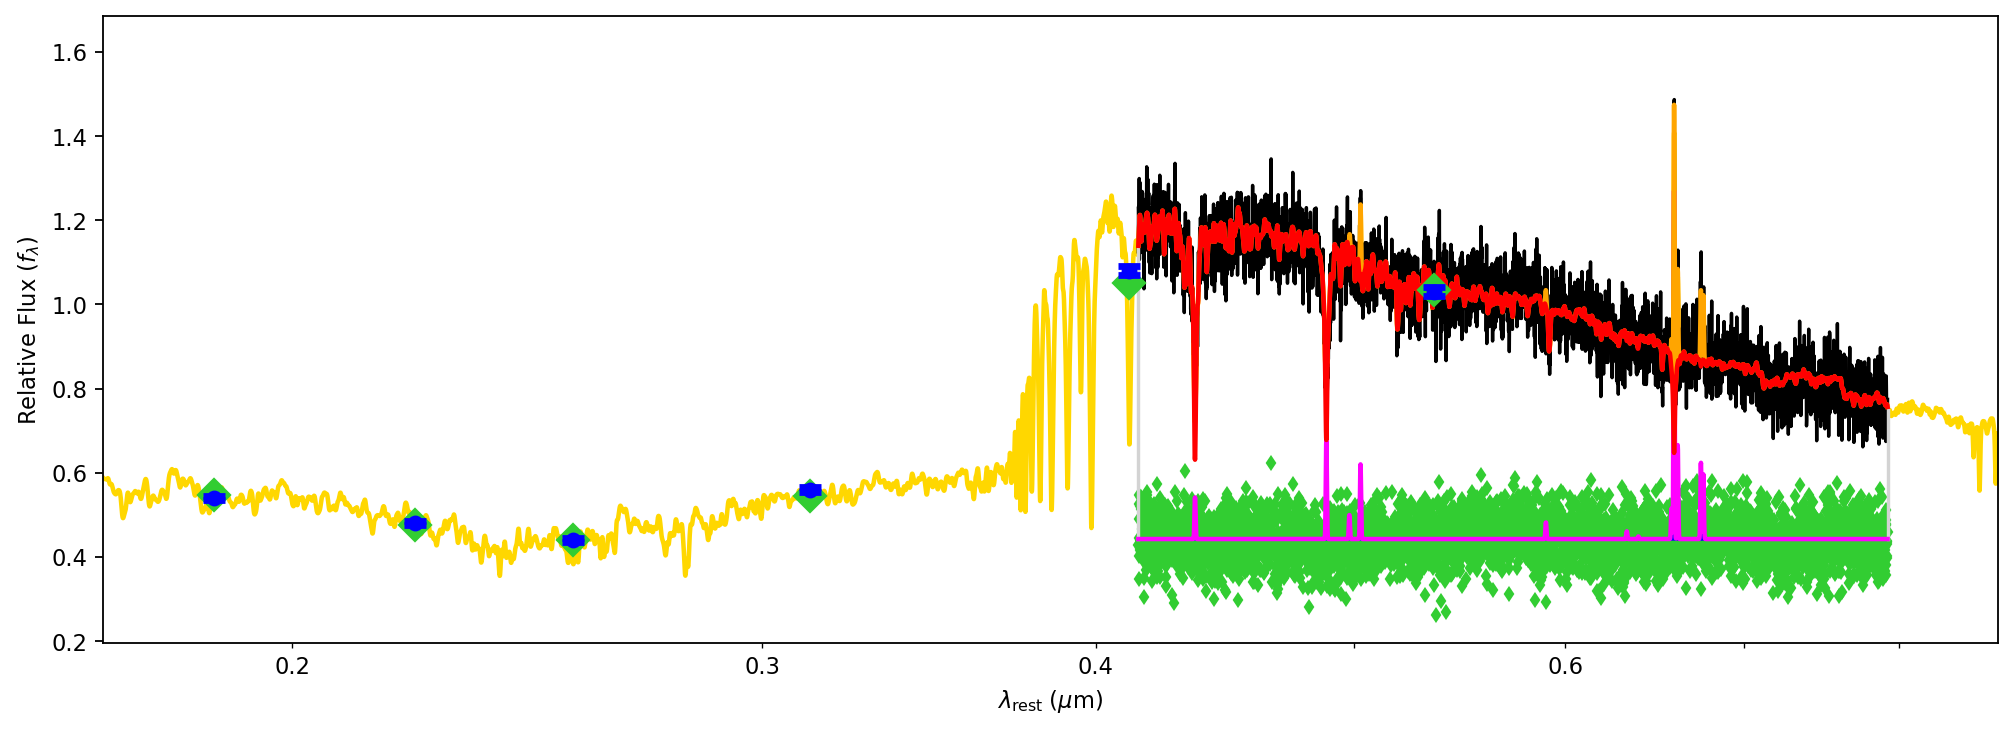

In [81]:
plt.figure(figsize=(15, 5))
pp.plot()

## Plot of the stellar population distribution

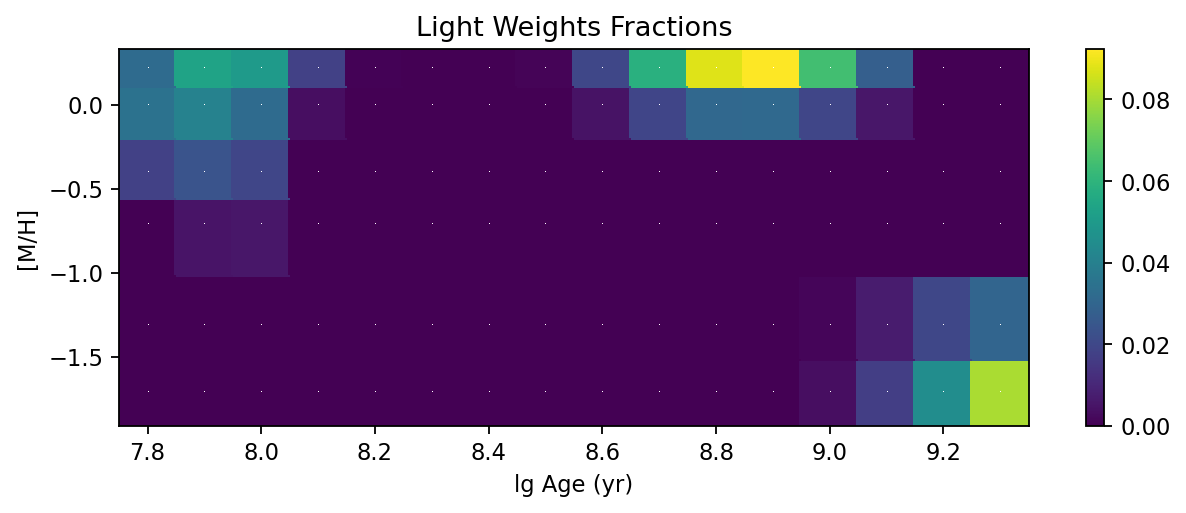

In [82]:
light_weights = pp.weights[~gas_component]      # Exclude weights of the gas templates
light_weights = light_weights.reshape(reg_dim)  # Reshape to (n_ages, n_metal)
light_weights /= light_weights.sum()            # Normalize to light fractions

plt.figure(figsize=(9,3))
miles.plot(light_weights)
plt.title("Light Weights Fractions");